In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

from keras.models import Sequential, Model
from keras import models
from keras import layers
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

import tqdm as tqdm

Using TensorFlow backend.


In [3]:
# add .png extension to photo_id; separate attributes
train_df = pd.read_csv("train_.csv")
train_df["attribute_ids"] = train_df["attribute_ids"].apply(lambda x: x.split(" "))
train_df["photo_id"] = train_df["photo_id"].apply(lambda x: x+".png")
train_df.head()

,photo_id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


In [4]:
label_df = pd.read_csv("labels.csv")
print(label_df.shape)
label_df[45:55]

(1103, 2)


,attribute_id,attribute_name
45,45,culture::bohemian
46,46,culture::bologna
47,47,culture::bordeaux
48,48,culture::bow
49,49,culture::brescia
50,50,culture::bristol
51,51,culture::british
52,52,culture::british or french
53,53,culture::british or scottish
54,54,culture::brunswick


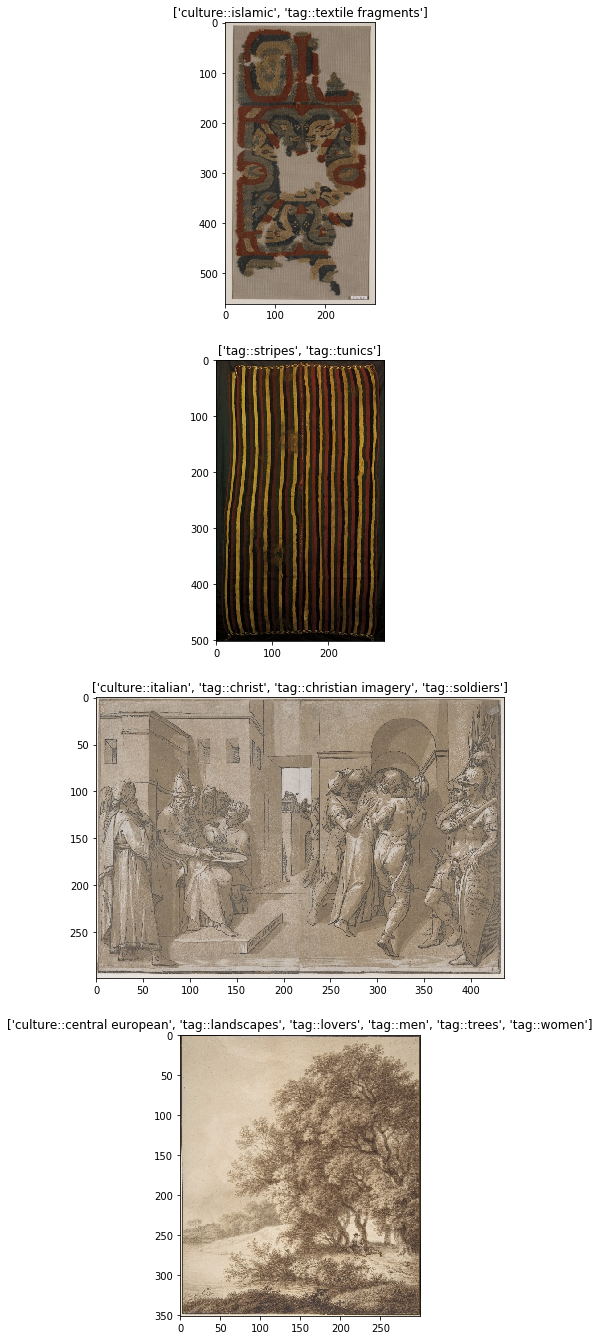

In [7]:
i = 1
plt.figure(figsize=[30,30])
for img_name in os.listdir("train")[6:10]:   
    img = cv2.imread("train/%s" % img_name)[...,[2, 1, 0]] #i think train/%s is saying to convert the path names into strings
                                                           # so that cv2.imread can read the photos (https://docs.python.org/3/
                                                           #library/stdtypes.html#printf-style-string-formatting)
    plt.subplot(5, 1, i)
    plt.imshow(img)
    ids = train_df[train_df["photo_id"] == img_name]["attribute_ids"]
    title_val = []
    for tag_id in ids.values[0]:
        att_name = label_df[label_df['attribute_id'].astype(str) == tag_id]['attribute_name'].values[0]
        title_val.append(att_name)
    plt.title(title_val)
    i += 1
    
plt.show()

In [5]:
nb_classes = 1103
batch_size = 300
img_size = 75
nb_epochs = 25

In [6]:
lbls = list(map(str, range(nb_classes)))

In [7]:
%%time

# set parameters for when we convert image data into tensors
train_datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train",
    x_col="photo_id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="train",
    x_col="photo_id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    classes=lbls,
    target_size=(img_size,img_size),
    subset='validation')

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 74 invalid image filename(s) in x_col="photo_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 81873 validated image filenames belonging to 1103 classes.
Found 27290 validated image filenames belonging to 1103 classes.
Wall time: 25.5 s


In [8]:
train_images, train_labels = next(train_generator)
valid_images, valid_labels = next(valid_generator)

In [9]:
train_images.shape

(300, 75, 75, 3)

In [10]:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = valid_images.reshape(valid_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)

(300, 16875)
(300, 16875)


##### set learning process

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(75 ,75,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [14]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_img,
                    train_labels,
                    epochs=5,
                    batch_size=512,
                    validation_data=(val_img, valid_labels))

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (300, 16875)